In [2]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hubertbudzynski","key":"11470a2a0d700acd10348e04d0bbca76"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:

!kaggle competitions download -c whats-cooking

  0% 0.00/426k [00:00<?, ?B/s]
100% 426k/426k [00:00<00:00, 58.9MB/s]
  0% 0.00/25.8k [00:00<?, ?B/s]
100% 25.8k/25.8k [00:00<00:00, 23.5MB/s]
  0% 0.00/1.76M [00:00<?, ?B/s]
100% 1.76M/1.76M [00:00<00:00, 58.6MB/s]


In [5]:
!unzip -q train.json.zip -d .
!unzip -q test.json.zip -d .
!ls

kaggle.json  sample_data		test.json      train.json
__MACOSX     sample_submission.csv.zip	test.json.zip  train.json.zip


In [6]:
!pip install tensorflow-text

     |████████████████████████████████| 3.4MB 6.5MB/s 


In [7]:
!pip install tf-models-official

     |████████████████████████████████| 1.1MB 3.9MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 276kB 60.5MB/s 
     |████████████████████████████████| 37.6MB 127kB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 358kB 63.8MB/s 
     |████████████████████████████████| 174kB 68.2MB/s 
     |████████████████████████████████| 1.2MB 67.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=3f2d645a267513fe345c574f1b9864538a5ca418884406b8bdbf0fd707ff5cbe
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=f991c88bbade9ba28d36a161e56d1deb4e8714e3cdc7d7722e13c68e9d665b56
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for py-cpui

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import tensorflow_text
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')

In [9]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recomended.')

Using TPU


In [10]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
bert_preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"

In [11]:
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

In [12]:
train_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [13]:
label_count = train_df['cuisine'].value_counts()
label_count['italian']

7838

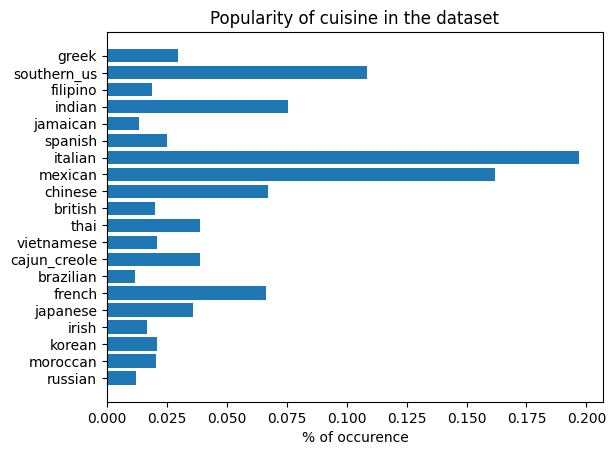

In [14]:
import matplotlib.pyplot as plt
y = train_df['cuisine'].to_numpy()

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
cuisine = pd.unique(train_df.cuisine)
y_pos = np.arange(len(cuisine))
occ = [label_count[c] / len(train_df) for c in cuisine]

ax.barh(y_pos, occ, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(cuisine)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of occurence')
ax.set_title('Popularity of cuisine in the dataset')

plt.show()

In [15]:
labels = pd.unique(train_df.cuisine)

In [16]:
labels_dict = {label : i for label, i in zip(labels, range(len(labels)))}

In [17]:
def ingredients_list_to_sentence(ingredients):
  ing_str = ', '.join(ingredients)
  sentence = 'cuisine with '
  sentence += ing_str
  return sentence

train_df.ingredients = train_df.ingredients.apply(lambda ingredients : ingredients_list_to_sentence(ingredients))
test_df.ingredients = test_df.ingredients.apply(lambda ingredients : ingredients_list_to_sentence(ingredients))

In [18]:
print(train_df.head())
print(test_df.head())

      id      cuisine                                        ingredients
0  10259        greek  cuisine with romaine lettuce, black olives, gr...
1  25693  southern_us  cuisine with plain flour, ground pepper, salt,...
2  20130     filipino  cuisine with eggs, pepper, salt, mayonaise, co...
3  22213       indian     cuisine with water, vegetable oil, wheat, salt
4  13162       indian  cuisine with black pepper, shallots, cornflour...
      id                                        ingredients
0  18009  cuisine with baking powder, eggs, all-purpose ...
1  28583  cuisine with sugar, egg yolks, corn starch, cr...
2  41580  cuisine with sausage links, fennel bulb, frond...
3  29752  cuisine with meat cuts, file powder, smoked sa...
4  35687  cuisine with ground black pepper, salt, sausag...


In [19]:
target_df = train_df.pop('cuisine')
ids = train_df.pop('id')

test_ids = test_df.pop('id')

In [20]:
target_df = target_df.apply(lambda x : labels_dict[x])

In [21]:
target_np = target_df.to_numpy()
targets = np.zeros((target_np.size, target_np.max()+1))
targets[np.arange(target_np.size),target_np] = 1

In [22]:
train_df.head()

,ingredients
0,"cuisine with romaine lettuce, black olives, gr..."
1,"cuisine with plain flour, ground pepper, salt,..."
2,"cuisine with eggs, pepper, salt, mayonaise, co..."
3,"cuisine with water, vegetable oil, wheat, salt"
4,"cuisine with black pepper, shallots, cornflour..."


In [23]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  bert_preprocess = hub.load(bert_preprocess_url)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  truncated_segments = segments

  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_dataset_from_df(dataset_df, targets, batch_size,
                           bert_preprocess_model):
  dataset = tf.data.Dataset.from_tensor_slices((bert_preprocess_model(dataset_df.values), targets))
  dataset = dataset.shuffle(buffer_size=1)
  
  DATASET_SIZE = len(targets)
  train_size = int(0.6 * DATASET_SIZE)
  val_size = int(0.2 * DATASET_SIZE)
  test_size = int(0.2 * DATASET_SIZE)

  train_dataset = dataset.take(train_size)
  test_dataset = dataset.skip(train_size)
  val_dataset = test_dataset.skip(test_size)
  test_dataset = test_dataset.take(test_size)

  train_dataset = train_dataset.batch(batch_size)
  test_dataset = test_dataset.batch(batch_size)
  val_dataset = val_dataset.batch(batch_size)

  train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return train_dataset, val_dataset, test_dataset

In [25]:
def build_classifier_model(num_classes):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(256), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(256), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(256), dtype=tf.int32),
  )

  encoder = hub.KerasLayer(module_url, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=0.5)(net)
  net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(inputs, net, name='prediction')

In [26]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

bert_preprocess_model = make_bert_preprocess_model([''], 256)

In [27]:
from official.nlp import optimization
history = {}
with strategy.scope():
  batch_size = 128
  tf.config.run_functions_eagerly(False)
  train_dataset, val_dataset, test_dataset = load_dataset_from_df(
      train_df, targets, batch_size, bert_preprocess_model)
  
  epochs = 20
  init_lr = 1e-5
  steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)
  validation_steps = tf.data.experimental.cardinality(val_dataset).numpy()

  classifier_model = build_classifier_model(20)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  metrics = tf.metrics.CategoricalAccuracy()
  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  history = classifier_model.fit(
      x=train_dataset,
      validation_data=val_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


187/187 [==============================] - 153s 483ms/step - loss: 3.3547 - categorical_accuracy: 0.0752 - val_loss: 2.0804 - val_categorical_accuracy: 0.4140
Epoch 2/20
187/187 [==============================] - 41s 218ms/step - loss: 1.9118 - categorical_accuracy: 0.4808 - val_loss: 1.2392 - val_categorical_accuracy: 0.6461
Epoch 3/20
187/187 [==============================] - 41s 219ms/step - loss: 1.2711 - categorical_accuracy: 0.6399 - val_loss: 1.0596 - val_categorical_accuracy: 0.6878
Epoch 4/20
187/187 [==============================] - 41s 219ms/step - loss: 1.0705 - categorical_accuracy: 0.6880 - val_loss: 0.9314 - val_categorical_accuracy: 0.7242
Epoch 5/20
187/187 [==============================] - 41s 219ms/step - loss: 0.9515 - categorical_accuracy: 0.7206 - val_loss: 0.8861 - val_categorical_accuracy: 0.7420
Epoch 6/20
187/187 [==============================] - 41s 219ms/step - loss: 0.8710 - categorical_accuracy: 0.7484 - val_loss: 0.8519 - val_categorical_accuracy: 0.7

In [28]:
classifier_model.evaluate(test_dataset)

63/63 [==============================] - 5s 64ms/step - loss: 0.8578 - categorical_accuracy: 0.7758


[0.8577914237976074, 0.7758360505104065]

Dodawanie dodatkowych warst Dense w modelu nigdy nie poprawiło wyniku, najlepsze wyniki były uzyskane dla Dropout 0.5

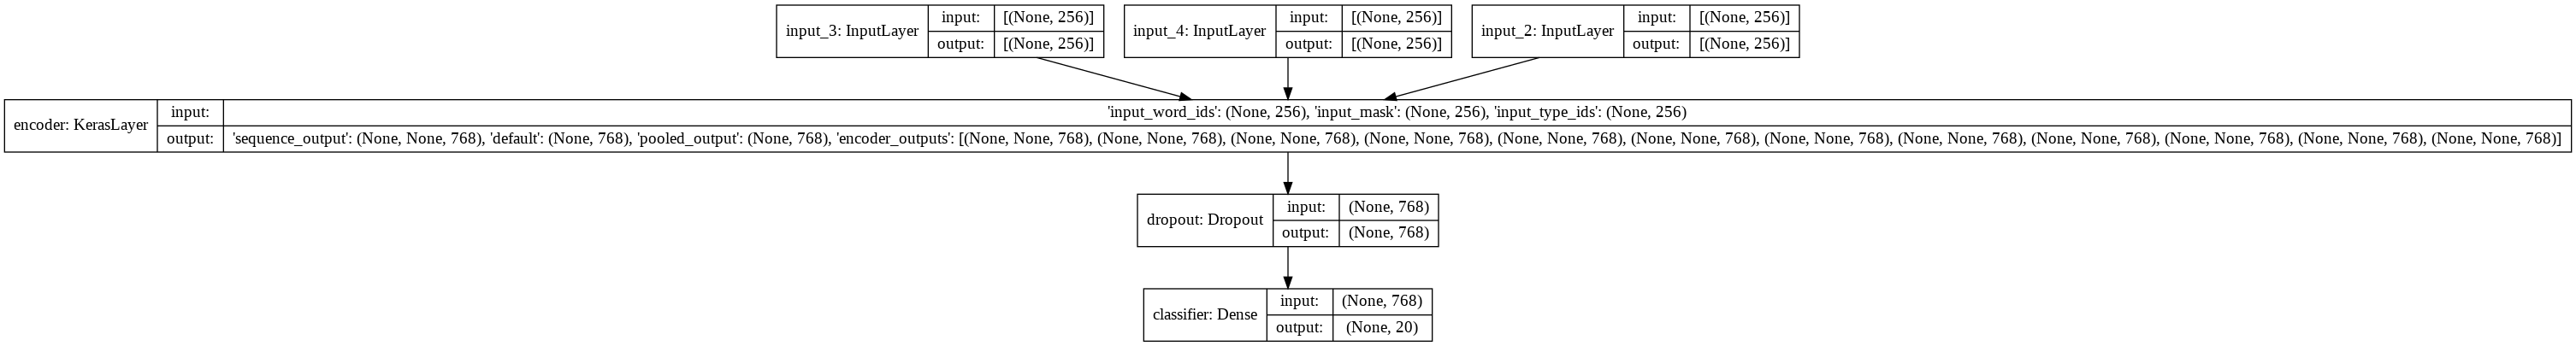

In [29]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True)

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


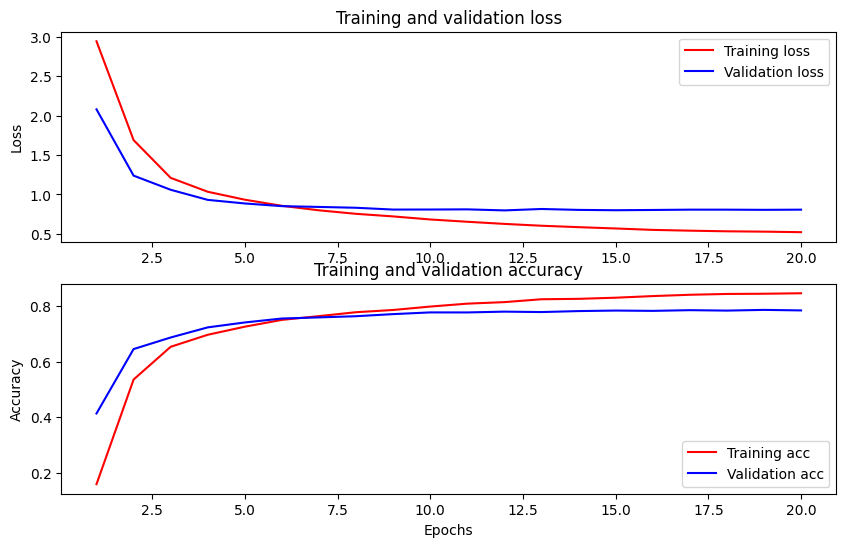

In [31]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [32]:
submission_dataset = tf.data.Dataset.from_tensor_slices(bert_preprocess_model(test_df.values)).batch(batch_size)

In [33]:
predictions = classifier_model.predict(submission_dataset)

In [34]:
predictions = [labels[np.argmax(prediction)] for prediction in predictions]

In [35]:
sub = {'id': test_ids, 'cuisine': predictions}
submission = pd.DataFrame(data=sub)

In [36]:
submission

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
...,...,...
9939,30246,french
9940,36028,mexican
9941,22339,italian
9942,42525,southern_us


In [37]:
submission.to_csv('bert_submission.csv', index=False)

In [38]:
!kaggle competitions submit -f bert_submission.csv -m "Bert submission" -c whats-cooking

100% 138k/138k [00:01<00:00, 116kB/s]
Successfully submitted to What's Cooking?